# Health Insurance Premium Prediction using Machine Learning
This notebook implements and extends the methodology described in the paper:  
**"Machine Learning-Based Regression Framework to Predict Health Insurance Premiums"**  
DOI: [10.3390/ijerph19137898](https://doi.org/10.3390/ijerph19137898)

We implement the baseline models and introduce three key extensions:
1. Hyperparameter Tuning
2. Advanced Regression Models (CatBoost, Ensemble)
3. SHAP-based Explainability

Metrics: **MAE**, **MSE**, **RMSE**, **R²**


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(url)

# Encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

# Split features and target
X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror')
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),  # Manually compute RMSE
        "R2": r2_score(y_test, y_pred)
    }

print(pd.DataFrame(results).T)


                           MAE           MSE         RMSE        R2
Linear Regression  4181.194474  3.359692e+07  5796.284659  0.783593
Decision Tree      3074.779629  4.000436e+07  6324.899900  0.742321
Random Forest      2562.589776  2.069137e+07  4548.776791  0.866721
XGBoost            2765.746813  2.343470e+07  4840.940468  0.849051


## Extension 1: Hyperparameter Tuning with RandomizedSearchCV
We apply tuning on Random Forest and XGBoost using cross-validation to improve prediction performance.

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Random Forest tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(rf, rf_params, cv=3, n_iter=5, scoring='neg_mean_squared_error', random_state=42)
rf_random.fit(X_train_scaled, y_train)
rf_best = rf_random.best_estimator_

# XGBoost tuning
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_random = RandomizedSearchCV(xgb_model, xgb_params, cv=3, n_iter=5, scoring='neg_mean_squared_error', random_state=42)
xgb_random.fit(X_train_scaled, y_train)
xgb_best = xgb_random.best_estimator_

# Evaluate tuned models
for name, model in [("Tuned RF", rf_best), ("Tuned XGBoost", xgb_best)]:
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Compatible RMSE calculation
    r2 = r2_score(y_test, y_pred)
    print(f"{name} -> RMSE: {rmse:.2f}, R²: {r2:.4f}")


Tuned RF -> RMSE: 4462.93, R²: 0.8717
Tuned XGBoost -> RMSE: 4679.59, R²: 0.8589


## Extension 2: Advanced Models (CatBoost + Ensemble)
We integrate CatBoost and build an ensemble model using VotingRegressor.

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train CatBoost
catboost = CatBoostRegressor(verbose=0)
catboost.fit(X_train_scaled, y_train)

# Ensemble Voting Regressor
ensemble = VotingRegressor([("catboost", catboost), ("xgb", xgb_best), ("rf", rf_best)])
ensemble.fit(X_train_scaled, y_train)

# Evaluate ensemble
y_pred_ensemble = ensemble.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
r2 = r2_score(y_test, y_pred_ensemble)

print(f"Ensemble -> RMSE: {rmse:.2f}, R²: {r2:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00
Ensemble -> RMSE: 4354.68, R²: 0.8779


## Extension 3: Explainability with SHAP
We use SHAP to explain the predictions of our best model.

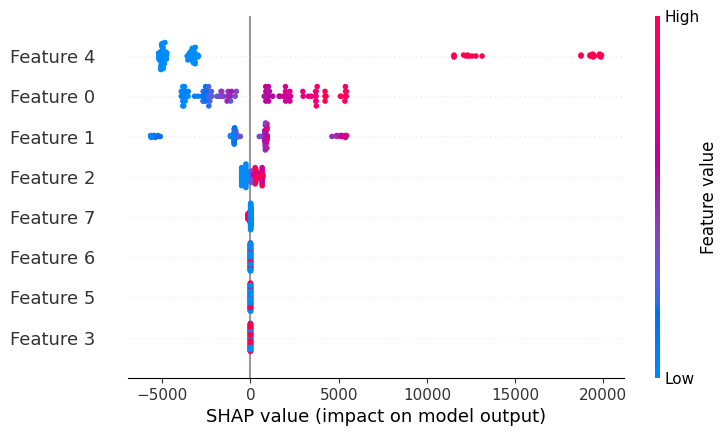

In [ ]:
import shap

explainer = shap.Explainer(xgb_best)  # or catboost
shap_values = explainer(X_test_scaled[:100])

shap.plots.beeswarm(shap_values)

